In [1]:
import pandas as pd
import numpy as np


1. To what extent do college sporting event outcomes correlate to reportable incidents?
1. Is Michigan State's campus more prone to incidents (correlated to the timing of sporting events) compared to Michigan?
1. What types of incidents are correlated to sport event outcomes?
1. Do games at certain times of the season have a correlation to frequency of incidents more than others?
1. "Do games at certain times" have a stronger correlation to incidents than other game times?



[Game classification](#big_game)\
[Analysis](#analysis)\
[Correlations](#corrs)\
[Distributions](#distributions)


In [2]:
df = pd.read_csv('../04_finaldata/full_data.csv')

# rename columns
df.rename({'start_dt': 'start', 'season_type': 'type', 'team_points': 'school_points', 'result': 'school_result',
           'ot': 'overtime', 'rank': 'school_rank', 'end_inc_window': 'end_window', 'opp_points': 'opponent_points'}, 
          axis=1, 
          inplace=True
         )

# reorder columns
df = df[['sport', 'school', 'opponent', 'game_id', 'start', 'incident_date', 'end_window', 'type', 'school_result', 
         'school_points', 'opponent_points', 'overtime', 'excitement_index', 'school_rank', 
         'opponent_rank', 'attendance', 'venue', 'incident_id', 'offense_id', 'offense_name']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714 entries, 0 to 1713
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sport             1714 non-null   object 
 1   school            1714 non-null   object 
 2   opponent          1714 non-null   object 
 3   game_id           1714 non-null   int64  
 4   start             1714 non-null   object 
 5   incident_date     1172 non-null   object 
 6   end_window        1714 non-null   object 
 7   type              1714 non-null   object 
 8   school_result     1714 non-null   int64  
 9   school_points     1714 non-null   int64  
 10  opponent_points   1714 non-null   int64  
 11  overtime          1714 non-null   int64  
 12  excitement_index  622 non-null    float64
 13  school_rank       1340 non-null   object 
 14  opponent_rank     514 non-null    float64
 15  attendance        759 non-null    float64
 16  venue             749 non-null    object 


In [3]:
# sort 'df' in chronological order
df = df.sort_values('start')

In [4]:
df['school'] = df['school'].replace('michigan-state', 'michigan state') # rename 'michigan-state' to 'michigan state'

In [5]:
# calculate score difference
df['score_diff'] = df['school_points'] - df['opponent_points']

In [6]:
# replace '-' characters w/ np.nan
df['school_rank'] = df['school_rank'].replace('-', np.nan)
df['opponent_rank'] = df['opponent_rank'].replace('-', np.nan)

In [7]:
# convert columns to floats
df['school_rank'] = df['school_rank'].astype('float')
df['opponent_rank'] = df['opponent_rank'].astype('float')

In [8]:
df['incident_date'] = pd.to_datetime(df['incident_date']) # convert 'incident_date' to datetime
df['incident_hour'] = df['incident_date'].dt.hour # create 'incident_hour' column
df['incident_month'] = df['incident_date'].dt.month # create 'incident_month' column

In [9]:
df['incident_hour'].isnull().value_counts() # how many rows have NaT from no incident available?

False    1172
True      542
Name: incident_hour, dtype: int64


#### Crime family classifications


In [10]:
# DataFrame w/ number of incidents per game as column
# will be 0 if no incident is found
df['incident_count'] = df.groupby(['game_id'])['incident_id'].transform('count')

In [11]:
offense_groups = {'Theft From Building': 'Theft', 
                  'Drug/Narcotic Violations': 'Substance Violation', 
                  'Simple Assault': 'Physical', 
                  'Destruction/Damage/Vandalism of Property': 'Property', 
                  'All Other Larceny': 'Theft',
                  'Theft From Motor Vehicle': 'Theft',
                  'Burglary/Breaking & Entering': 'Theft',
                  'Aggravated Assault': 'Physical',
                  'Intimidation': 'Physical',
                  'False Pretenses/Swindle/Confidence Game': 'Scam',
                  'Credit Card/Automated Teller Machine Fraud': 'Scam',
                  'Counterfeiting/Forgery': 'Scam',
                  'Fondling': 'Sexual',
                  'Motor Vehicle Theft': 'Theft',
                  'Robbery': 'Theft',
                  'Rape': 'Sexual',
                  'Shoplifting': 'Theft',
                  'Pocket-picking': 'Theft',
                  'Arson': 'Property',
                  'Stolen Property Offenses': 'Property',
                  'Theft of Motor Vehicle Parts or Accessories': 'Theft',
                  'Extortion/Blackmail': 'Scam',
                  'Theft From Coin-Operated Machine or Device': 'Theft',
                  'Sexual Assault With An Object': 'Sexual',
                  'Weapon Law Violations': 'Weapon Violation',
                  'Drug Equipment Violations': 'Substance Violation',
                  'Purse-snatching': 'Theft',
                  'Sodomy': 'Sexual',
                  'Embezzlement': 'Scam',
                  'Identity Theft': 'Scam',
                  'Impersonation': 'Scam',
                  'Animal Cruelty': 'Animal Cruelty',
                  'Wire Fraud': 'Scam',
                  'Kidnapping/Abduction': 'Physical',
                 }

df['offense_map'] = df['offense_name'].map(offense_groups) 

In [12]:
one_hot = pd.get_dummies(df['offense_map'])
df = pd.concat([df, one_hot], axis=1)

In [13]:
# crime group for game w/ sum for game in each row 
for crime in df['offense_map'].unique():
    if type(crime) == type('str'): # only accept strings and ignore np.nan
        df[crime+' sum'] = df.groupby(['game_id'])[crime].transform('sum')

In [14]:
# check to see transform loop worked:
# df.iloc[10:20, [3, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]]


#### Poll rank column designations


In [15]:
rank_list = [25, 20, 15, 10, 5]
for rank in rank_list:
    df['top_' + str(rank) + '_matchup'] = np.where((df['school_rank'] <= rank) & (df['opponent_rank'] <= rank), 1, 0)

In [16]:
df[df['top_5_matchup'] == 1][['school', 'opponent', 'school_rank', 'opponent_rank', 'top_5_matchup']][:10]

,school,opponent,school_rank,opponent_rank,top_5_matchup
1032,michigan,indiana (3),1.0,3.0,1
1034,michigan,indiana (3),1.0,3.0,1
1035,michigan,indiana (3),1.0,3.0,1
1033,michigan,indiana (3),1.0,3.0,1
136,michigan state,indiana (1),4.0,1.0,1
1562,michigan state,kentucky (1),2.0,1.0,1
1286,michigan state,ohio state (3),5.0,3.0,1
412,michigan state,iowa,5.0,4.0,1
413,michigan state,iowa,5.0,4.0,1
414,michigan state,iowa,5.0,4.0,1


In [17]:
df['poll_diff'] = df['school_rank'] - df['opponent_rank']


#### LabelEncoder()


In [18]:
df['score_quantile'] = pd.qcut(df['score_diff'], 4, labels=[1, 2, 3, 4])

In [19]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['score_quantile'] = enc.fit_transform(df['score_quantile'])
df['score_quantile'].unique()

array([3, 1, 0, 2], dtype=int64)

In [20]:
enc = LabelEncoder()
df['venue_enc'] = enc.fit_transform(df['venue'])
df['venue_enc'].unique()

array([17, 10, 11,  3,  9,  6, 19, 21, 15, 16,  2, 12,  5, 13,  1,  4,  8,
       14, 20,  7,  0, 18])

In [21]:
df['venue_enc'].replace(17, 23, inplace=True)
df['venue_enc'].replace(10, 24, inplace=True)

In [22]:
df[['venue', 'venue_enc']]

,venue,venue_enc
318,Spartan Stadium,23
1657,Michigan Stadium,24
57,Spartan Stadium,23
59,Spartan Stadium,23
60,Spartan Stadium,23
...,...,...
921,Memorial Stadium,9
920,Memorial Stadium,9
919,Memorial Stadium,9
1556,Michigan Stadium,24


In [23]:
df['venue_enc'].unique()

array([23, 24, 11,  3,  9,  6, 19, 21, 15, 16,  2, 12,  5, 13,  1,  4,  8,
       14, 20,  7,  0, 18])

In [24]:
df[['score_diff', 'score_quantile']].sample(15)

,score_diff,score_quantile
945,-10,0
1002,52,3
1378,9,2
761,7,1
916,-1,1
995,-7,0
1569,11,2
1017,20,3
339,11,2
205,28,3


In [25]:
# groupby_gameid = df.groupby('game_id') # this is used nowhere else - should toss


<a id='big_game'></a>



&nbsp;

## Game classification


In [26]:
# https://stackoverflow.com/questions/30631841/pandas-how-do-i-assign-values-based-on-multiple-conditions-for-existing-columns

conditions = [
    df['top_5_matchup'].eq(1),
    df['top_10_matchup'].eq(1),
    df['top_15_matchup'].eq(1),
    df['top_20_matchup'].eq(1),
    df['top_25_matchup'].eq(1)
]

choices = [1, 2, 3, 4, 5]

df['top_matchup'] = np.select(conditions, choices, default=np.nan)

In [27]:
conditions = [df['school'].eq('michigan') 
              & df['opponent'].isin(['ohio state', 'notre dame', 'michigan state', 'michigan-state']), 
              df['school'].eq('michigan state') & df['opponent'].isin(['michigan'])
             ]

choices = [1, 1]
df['rivalry'] = np.select(conditions, choices, default=0)


&nbsp;


In [28]:
# create a DataFrame where counts of incidents + crime types are counted / summed, and each game is a single row
df_onerow = df.drop_duplicates('game_id')

<a id='analysis'></a>


&nbsp;

## Analysis


In [29]:
df[df.incident_date.isnull()][:5]

,sport,school,opponent,game_id,start,incident_date,end_window,type,school_result,school_points,...,top_25_matchup,top_20_matchup,top_15_matchup,top_10_matchup,top_5_matchup,poll_diff,score_quantile,venue_enc,top_matchup,rivalry
1512,football,michigan state,wisconsin,135,2009-09-26 12:00:00,NaT,2009-09-26 23:00:00,regular,0,30,...,0,0,0,0,0,NaN,0,3,NaN,0
1626,basketball,michigan state,florida gulf coast,628,2009-11-13 19:00:00,NaT,2009-11-14 05:00:00,regular,1,97,...,0,0,0,0,0,NaN,3,21,NaN,0
1051,football,michigan,wisconsin,10,2009-11-14 12:00:00,NaT,2009-11-14 23:00:00,regular,0,24,...,0,0,0,0,0,NaN,0,3,NaN,0
904,basketball,michigan state,gonzaga,629,2009-11-17 20:00:00,NaT,2009-11-18 06:00:00,regular,1,75,...,0,0,0,0,0,NaN,1,21,NaN,0
1285,basketball,michigan state,toledo,630,2009-11-20 18:30:00,NaT,2009-11-21 04:30:00,regular,1,75,...,0,0,0,0,0,NaN,2,21,NaN,0


In [30]:
len(df[df.incident_date.isnull()]['game_id'].drop_duplicates()) # check NaT values each belong to games w/ no incidents

542

In [31]:
# what's the mean number of incidents generated from football rivlary games?
for sport in df['sport'].unique():
    print(df[(df['rivalry'] == 1) 
             & (df['sport'] == sport)
            ]
          .groupby('start')['incident_id'].agg('count').mean(),
          'incidents on average for ' + sport + ' rivalry games')

4.7 incidents on average for football rivalry games
0.75 incidents on average for basketball rivalry games



&nbsp;

#### Testing


In [32]:
# before
print(len(df[df['top_' + str(25) + '_matchup'] == 1]) / len(df))

0.17444574095682613


In [33]:
# after
notnulltop25 = len(df[(df['top_' + str(25) + '_matchup'] == 1) & (df['incident_date'].notnull())])
notnulls = len(df[df['incident_date'].notnull()])
print(notnulltop25, '\n', notnulls, '\n', (notnulltop25 / notnulls))

198 
 1172 
 0.1689419795221843



&nbsp;



#### Percentages


In [34]:
# count %age of incidents our of whole for each ranking group
for rank in rank_list:
    print('{:.1%}'.format(len(df[(df['top_' + str(rank) + '_matchup'] == 1) & (df['incident_date'].notnull())]
                             )
                          / len(df[df['incident_date'].notnull()])
                         ), 'of incidents are related to top ' + str(rank) + ' games'
         )

16.9% of incidents are related to top 25 games
12.5% of incidents are related to top 20 games
7.5% of incidents are related to top 15 games
4.1% of incidents are related to top 10 games
0.9% of incidents are related to top 5 games


In [35]:
# how many games in the entire set were top 25 matchups, top 20 matchups...
for rank in rank_list:
    print(len(df_onerow[df_onerow['top_' + str(rank) + '_matchup'] == 1]), 
          'out of', 
          len(df_onerow), 
          ' top ' + str(rank) + ' matchups -', 
          '{:.1%}'.format(len(df_onerow[df_onerow['top_' + str(rank) + '_matchup'] == 1]) / len(df_onerow)), 'percent')

166 out of 993  top 25 matchups - 16.7% percent
130 out of 993  top 20 matchups - 13.1% percent
74 out of 993  top 15 matchups - 7.5% percent
42 out of 993  top 10 matchups - 4.2% percent
9 out of 993  top 5 matchups - 0.9% percent


In [36]:
# what %age of incidents are associated w/ ranked games when Michigan or Michigan State lost?
print('For games where Michigan or Michigan State lost:\n')
for rank in rank_list:
    print('{:.1%}'.format(len(df[(df['top_' + str(rank) + '_matchup'] == 1) 
                                 & (df['incident_date'].notnull())
                                 & (df['school_result'] == 0)]) 
                          / len(df[(df['school_result'] == 0) & (df['incident_date'].notnull())])
                         ), 
          'of incidents attributable to top ' + str(rank) + ' games '
         )

For games where Michigan or Michigan State lost:

28.7% of incidents attributable to top 25 games 
21.3% of incidents attributable to top 20 games 
13.6% of incidents attributable to top 15 games 
6.4% of incidents attributable to top 10 games 
1.6% of incidents attributable to top 5 games 


In [37]:
# what %age of incidents are associated w/ ranked games when Michigan or Michigan State won?
print('For games where Michigan or Michigan State won:\n')
for rank in rank_list:
    print('{:.1%}'.format(len(df[(df['top_' + str(rank) + '_matchup'] == 1) 
                                 & (df['incident_date'].notnull())
                                 & (df['school_result'] == 1)])
                          / len(df[(df['school_result'] == 1) & (df['incident_date'].notnull())])
                         ), 
          'of incidents attributable to top ' + str(rank) + ' games '
         )

For games where Michigan or Michigan State won:

11.3% of incidents attributable to top 25 games 
8.3% of incidents attributable to top 20 games 
4.6% of incidents attributable to top 15 games 
3.0% of incidents attributable to top 10 games 
0.5% of incidents attributable to top 5 games 



&nbsp;

#### Where losses occurred


In [38]:
df_cfbl = df[(df['school_result'] == 0) 
                & (df['sport'] == 'football') 
                & (df['incident_date'].notnull()) # drop rows w/out incidents (NaT values)
               ]

# what about if it's just football losses?
print('For football games where Michigan or Michigan State lost:\n')
for rank in rank_list:
    print('{:.1%}'.format(len(df_cfbl[df_cfbl['top_' + str(rank) + '_matchup'] == 1]) 
                          / len(df_cfbl)
                         ), 
          'top ' + str(rank) + ' CFB where Michigan / Michigan State lost'
         )

For football games where Michigan or Michigan State lost:

31.8% top 25 CFB where Michigan / Michigan State lost
25.3% top 20 CFB where Michigan / Michigan State lost
17.1% top 15 CFB where Michigan / Michigan State lost
6.5% top 10 CFB where Michigan / Michigan State lost
0.9% top 5 CFB where Michigan / Michigan State lost


In [39]:
# incidents from games where Michigan / Michigan State lost a rivalry game
print('{:.1%}'.format(len(df_cfbl[(df_cfbl['rivalry'] == 1)])
                      / len(df_cfbl)), 
      'of incidents from Michigan / Michigan State CFB games where losses occurred were from rivalry games'
     )

35.0% of incidents from Michigan / Michigan State CFB games where losses occurred were from rivalry games



People tend to react more when it's a rivalry game w/ a loss.



&nbsp;

#### Where wins occurred


In [40]:
df_cfbw = df[(df['school_result'] == 1) 
               & (df['sport'] == 'football') 
               & (df['incident_date'].notnull()) # drop rows w/out an incident )
              ]

# what about if it's just football wins?
for rank in rank_list:
    print('{:.1%}'.format(len(df_cfbw[df_cfbw['top_' + str(rank) + '_matchup'] == 1]) 
                          / len(df_cfbw)
                         ), 
          'top ' + str(rank) + ' CFB where Michigan / Michigan State won'
         )

14.9% top 25 CFB where Michigan / Michigan State won
11.1% top 20 CFB where Michigan / Michigan State won
6.0% top 15 CFB where Michigan / Michigan State won
3.8% top 10 CFB where Michigan / Michigan State won
0.8% top 5 CFB where Michigan / Michigan State won


In [41]:
# winning a football rivalry game?
print('{:.1%}'.format(len(df_cfbw[(df_cfbw['rivalry'] == 1)])
                      / len(df_cfbw)), 'of incidents from Michigan / Michigan State CFB games where wins occurred were from rivalry games')

13.1% of incidents from Michigan / Michigan State CFB games where wins occurred were from rivalry games


In [42]:
# number of ranked football games Michigan + Michigan State lost
len(df_cfbl[(df_cfbl['top_25_matchup'] == 1)])

69


&nbsp;


In [43]:
# what is the mean number of incidents for top matchups by ranking bracket (25, 20, 15, 10, 5)?
for rank in rank_list:
    print('{:.2f}'.format(df[df['top_' + str(rank) + '_matchup'] == 1]
                          .groupby('start')['incident_id'].agg('count')
                          .mean()
                         ), 
          'mean incidents for a top ' + str(rank) + ' matchup'
         )

1.32 mean incidents for a top 25 matchup
1.22 mean incidents for a top 20 matchup
1.31 mean incidents for a top 15 matchup
1.30 mean incidents for a top 10 matchup
1.11 mean incidents for a top 5 matchup


In [44]:
print('{:.2f}'.format(df[df['sport'] == 'football'].groupby('game_id')['incident_id'].agg('count').mean()), '\n')

# what is the mean number of incidents for top matchups by ranking bracket (25, 20, 15, 10, 5) when it is only football?
for rank in rank_list:
    print('{:.2f}'.format(df[(df['top_' + str(rank) + '_matchup'] == 1) 
                       & (df['sport'] == 'football')]
                    .groupby('start')['incident_id'].agg('count')
                    .mean()
                   ), 
          'mean incidents per game for top ' + str(rank) + ' games'
         )

2.67 

3.11 mean incidents per game for top 25 games
2.89 mean incidents per game for top 20 games
3.35 mean incidents per game for top 15 games
3.00 mean incidents per game for top 10 games
3.00 mean incidents per game for top 5 games


In [45]:
# only two football games were top 5 matchups
(df_onerow[(df_onerow['sport'] == 'football') 
          & (df_onerow['top_5_matchup'] == 1)]
[['school', 'opponent', 'school_rank', 'opponent_rank']])

,school,opponent,school_rank,opponent_rank
412,michigan state,iowa,5.0,4.0
1196,michigan,ohio state,3.0,2.0


In [46]:
print('{:.2f}'.format(df[df['sport'] == 'basketball']
                      .groupby('game_id')['incident_id'].agg('count')
                      .mean()
                     ),
      'mean incidents for any basketball game \n'
     )

# what is the mean number of incidents for top matchups by ranking bracket (25, 20, 15, 10, 5) when it is only basketball?
for rank in rank_list:
    print('{:.2f}'.format(df[(df['top_' + str(rank) + '_matchup'] == 1) 
                             & (df['sport'] == 'basketball')]
                          .groupby('game_id')['incident_id'].agg('count')
                          .mean()
                         ),
          'mean incidents per game for top ' + str(rank) + ' games'
         )

0.63 mean incidents for any basketball game 

0.48 mean incidents per game for top 25 games
0.40 mean incidents per game for top 20 games
0.40 mean incidents per game for top 15 games
0.48 mean incidents per game for top 10 games
0.57 mean incidents per game for top 5 games


In [47]:
print('{:.2f}'.format(df[(df['rivalry'] == 1) & (df['sport'] == 'basketball')]
                      .groupby('game_id')['incident_id'].agg('count')
                      .mean()
                     ),
      'mean incidents for basketball rivlary games'
     )

0.57 mean incidents for basketball rivlary games



Possible confounding factors exist for basketball, like weather for the time of year and games played mid-week vs. Saturday.



<a id='corrs'></a>



&nbsp;

## Correlations


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
corr_list = ['school_result', 'start', 'offense_name', 'overtime', 'rivalry', 'top_matchup', 
'excitement_index', 'venue_enc', 'score_quantile', 'incident_count', 'incident_hour', 'incident_month', 
'Theft', 'Scam', 'Property', 'Substance Violation', 'Physical', 'Sexual',
'Weapon Violation', 'Animal Cruelty']

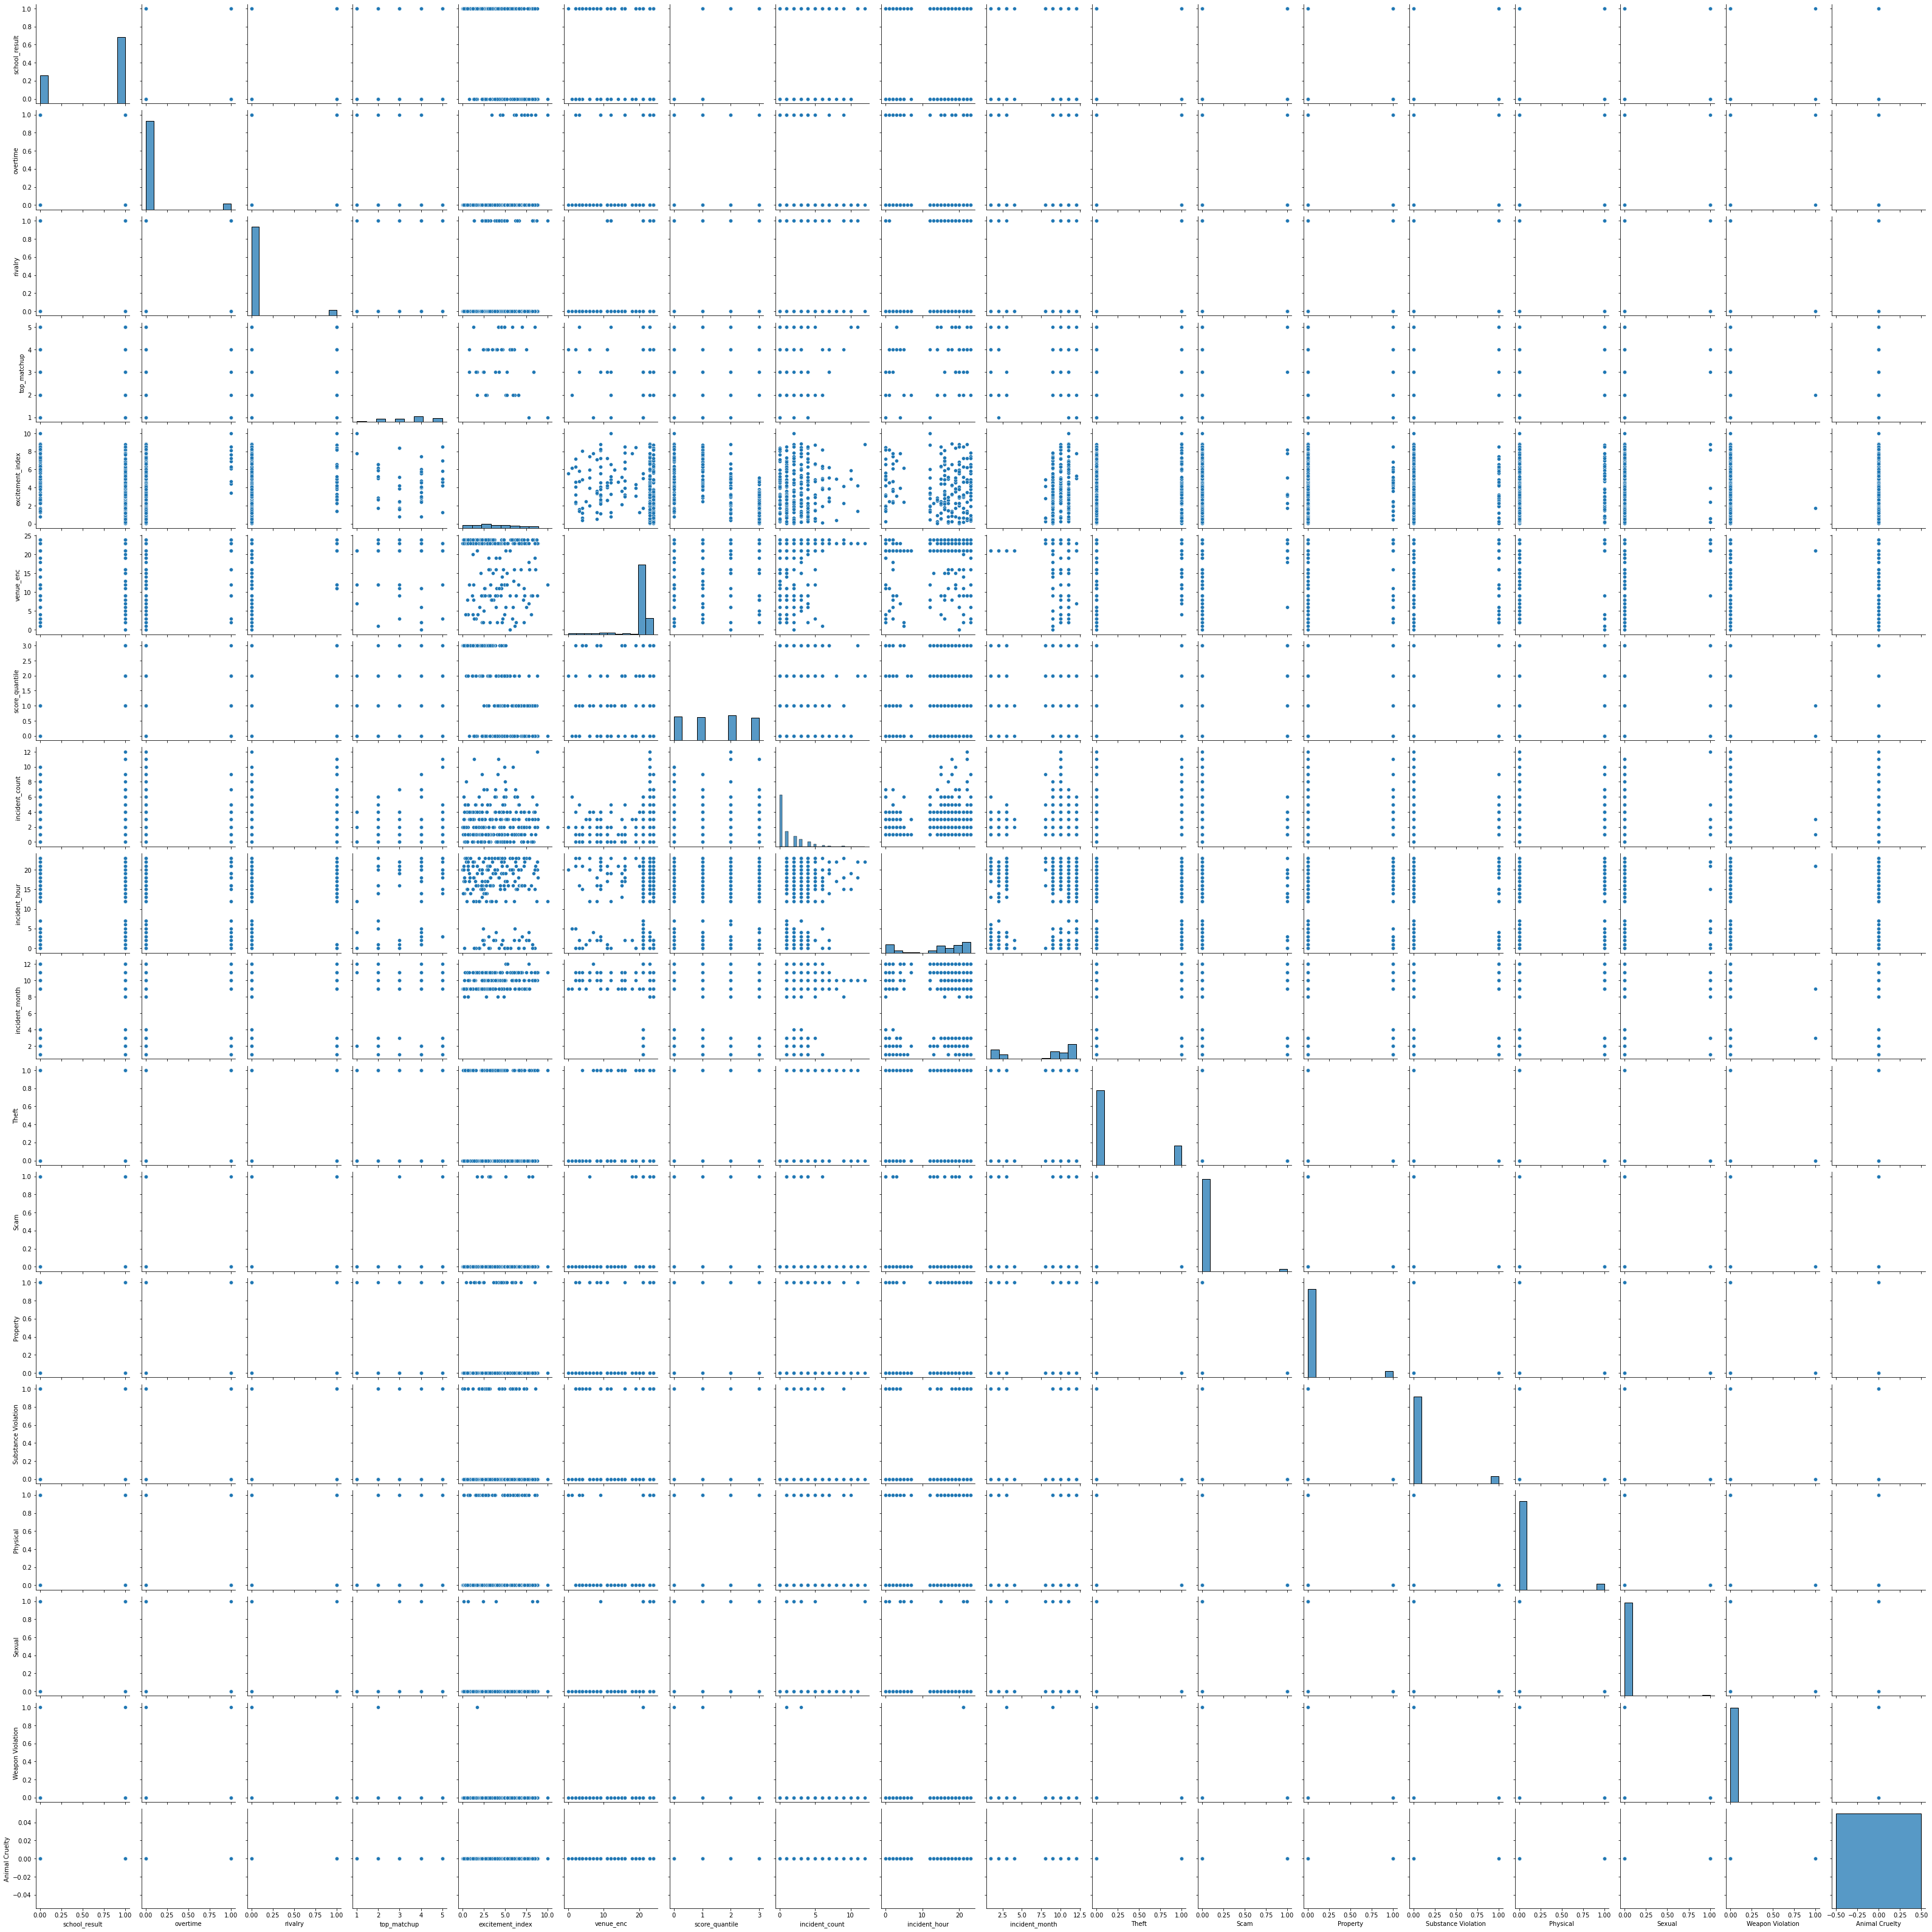

In [50]:
sns.pairplot(df_onerow[corr_list])

In [51]:
len(df_onerow[(df_onerow['sport'] == 'football') & (df_onerow['school'] == 'michigan state')])

135

In [72]:
(df_onerow[(df_onerow['sport'] == 'football') & (df_onerow['school'] == 'michigan state') & (df_onerow['rivalry'] == 1)]
[['school', 'opponent', 'start', 'score_diff', 'rivalry', 'venue', 'Theft sum', 'Physical sum', 'Property sum']]
 .sort_values('Physical sum', ascending=False))[0:50]

,school,opponent,start,score_diff,rivalry,venue,Theft sum,Physical sum,Property sum
1551,michigan state,michigan,2014-10-25 15:30:00,24,1,Spartan Stadium,1,8,2
1107,michigan state,michigan,2018-10-20 12:00:00,-14,1,Spartan Stadium,2,6,1
876,michigan state,michigan,2011-10-15 12:00:00,14,1,Spartan Stadium,3,4,1
933,michigan state,michigan,2009-10-03 12:00:00,6,1,Spartan Stadium,4,2,3
1214,michigan state,michigan,2016-10-29 12:00:00,-9,1,Spartan Stadium,6,1,1
537,michigan state,michigan,2017-10-07 19:30:00,4,1,Michigan Stadium,1,1,0
1557,michigan state,michigan,2010-10-09 15:30:00,17,1,Michigan Stadium,0,0,0
899,michigan state,michigan,2012-10-20 15:30:00,-2,1,Michigan Stadium,0,0,0
664,michigan state,michigan,2013-11-02 15:30:00,23,1,Spartan Stadium,2,0,1
395,michigan state,michigan,2015-10-17 15:30:00,4,1,Michigan Stadium,0,0,0


<AxesSubplot:>

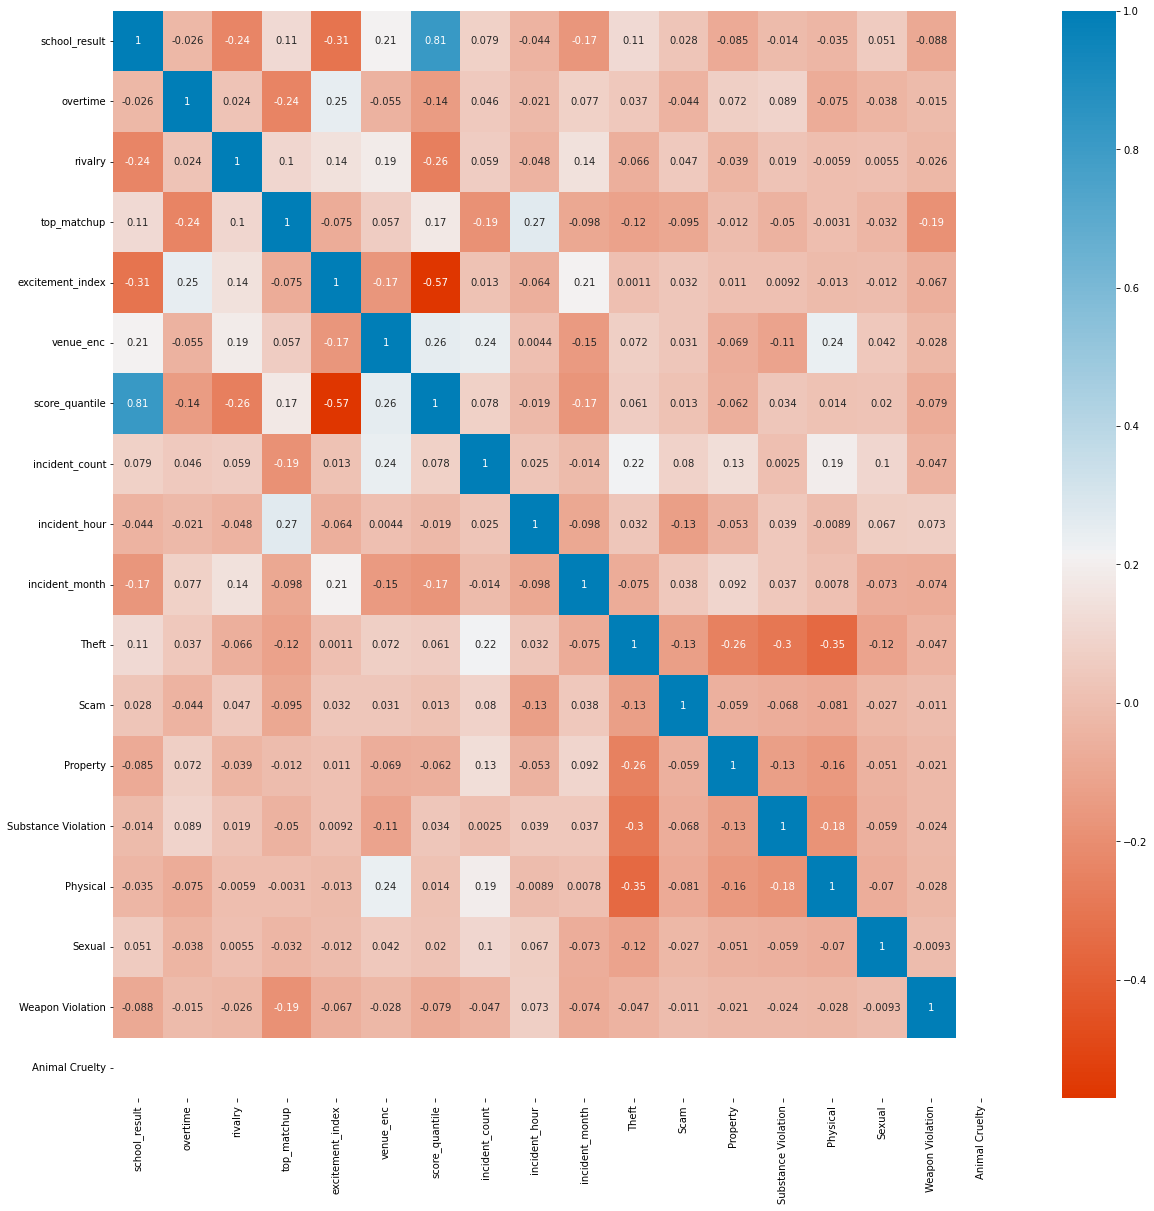

In [53]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap((df_onerow[df_onerow['sport'] == 'football']
             [corr_list]
            )
            .corr(method='spearman'), 
            cmap=sns.diverging_palette(16, 240, s=100, l=50, as_cmap=True), 
            annot=True, 
            annot_kws={"fontsize":10}
           )

<AxesSubplot:>

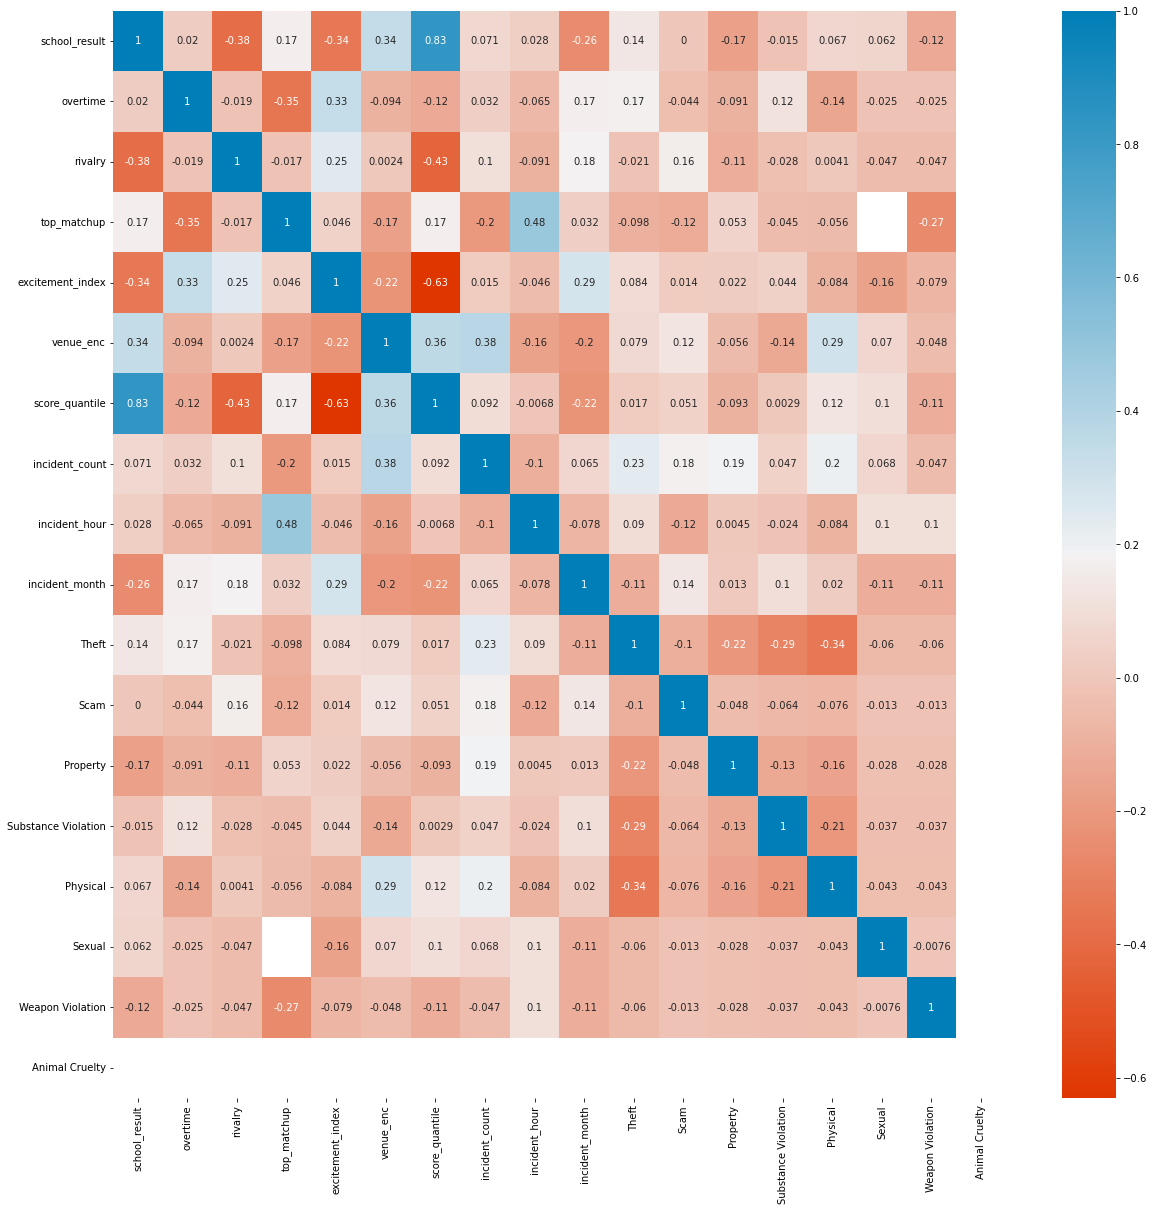

In [54]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(((df_onerow[(df_onerow['sport'] == 'football') 
                        & (df_onerow['school'] == 'michigan')]
             )
             [corr_list]
            )
            .corr(method='spearman'), 
            cmap=sns.diverging_palette(16, 240, s=100, l=50, as_cmap=True), 
            annot=True, 
            annot_kws={"fontsize":10}
           )

<AxesSubplot:>

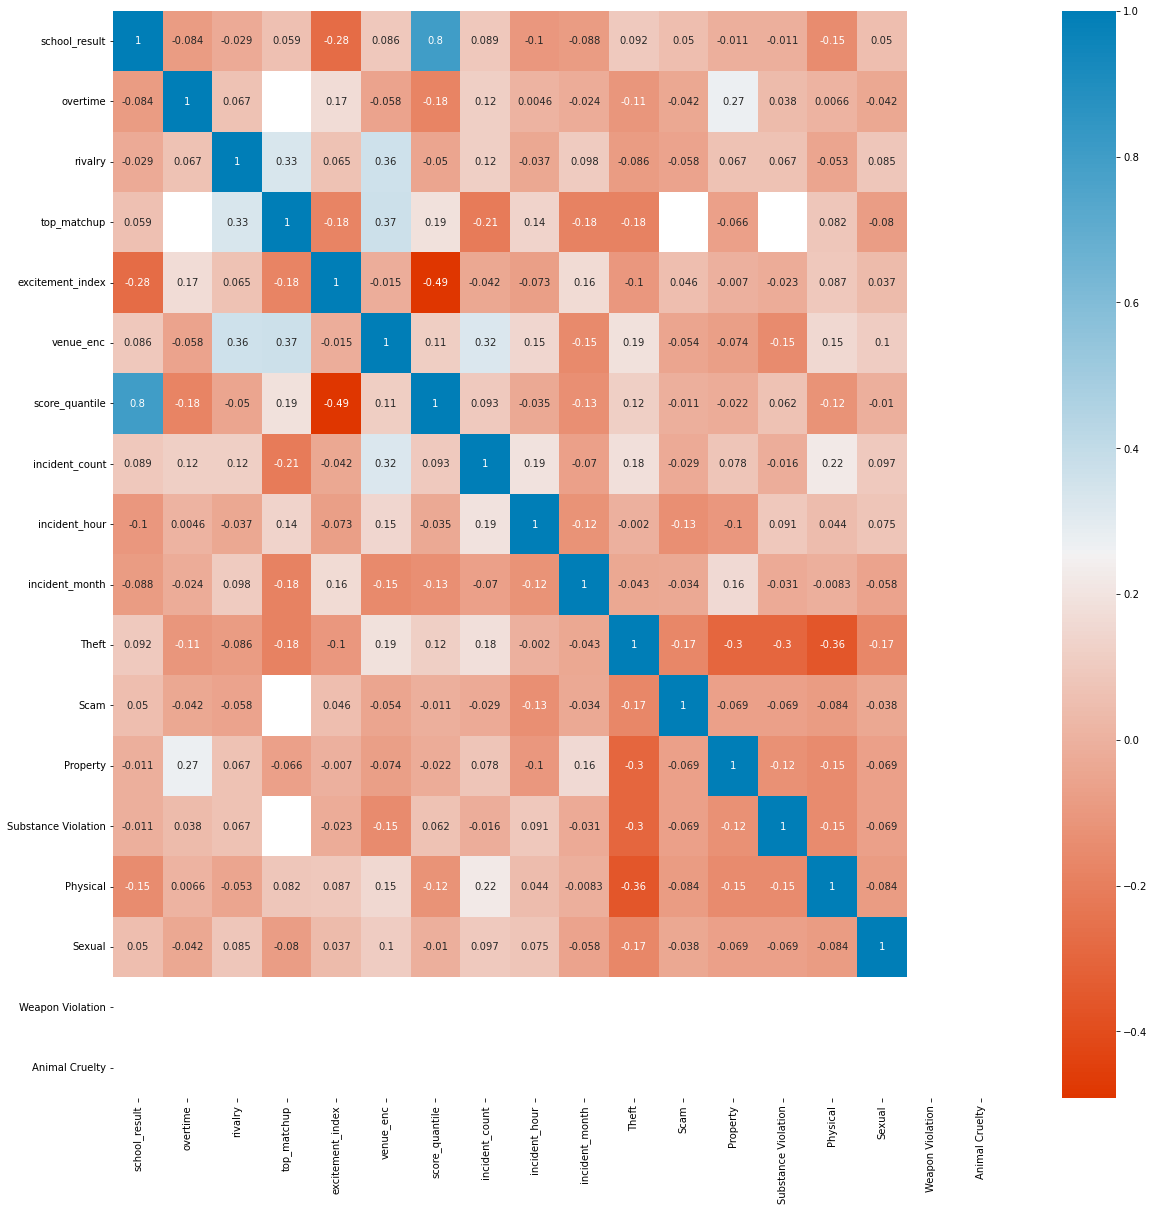

In [55]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(((df_onerow[(df_onerow['sport'] == 'football') 
                        & (df_onerow['school'] == 'michigan state')]
             )
             [corr_list]
            )
            .corr(method='spearman'), 
            cmap=sns.diverging_palette(16, 240, s=100, l=50, as_cmap=True), 
            annot=True, 
            annot_kws={"fontsize":10}
           )

<a id='distributions'></a>


&nbsp;

## Distributions


In [56]:
for rank in rank_list:
    print('top ' + str(rank))
    print(df_onerow[(df_onerow['top_' + str(rank) + '_matchup'] == 1) 
                    & (df_onerow['sport'] == 'football')]
          ['incident_count']
          .describe(), '\n')

top 25
count    51.000000
mean      2.803922
std       2.800140
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      11.000000
Name: incident_count, dtype: float64 

top 20
count    40.000000
mean      2.750000
std       2.457328
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       9.000000
Name: incident_count, dtype: float64 

top 15
count    21.000000
mean      3.190476
std       2.204973
min       0.000000
25%       1.000000
50%       4.000000
75%       4.000000
max       7.000000
Name: incident_count, dtype: float64 

top 10
count    11.000000
mean      3.000000
std       2.097618
min       0.000000
25%       1.500000
50%       2.000000
75%       4.500000
max       6.000000
Name: incident_count, dtype: float64 

top 5
count    2.000000
mean     3.000000
std      1.414214
min      2.000000
25%      2.500000
50%      3.000000
75%      3.500000
max      4.000000
Name: incident_count, dtype: float64 



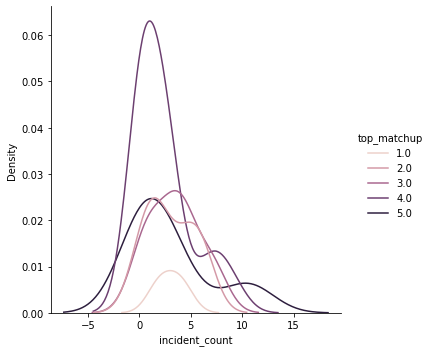

In [57]:
sns.displot(df_onerow[df_onerow['sport'] == 'football'], x='incident_count', hue='top_matchup', kind='kde')

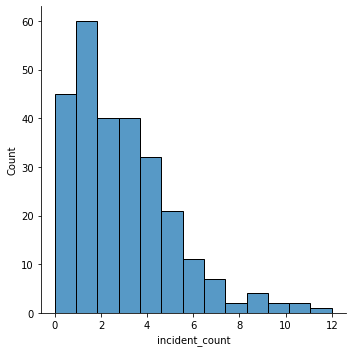

In [58]:
sns.displot(df_onerow[df_onerow['sport'] == 'football'], x='incident_count')

In [59]:
df[df['sport'] == 'football']['incident_hour'].value_counts()

23.0    69
17.0    66
12.0    60
16.0    57
20.0    55
18.0    51
22.0    49
19.0    47
0.0     46
21.0    45
15.0    38
13.0    35
2.0     29
14.0    29
1.0     19
3.0      8
4.0      7
5.0      4
Name: incident_hour, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='top_matchup', ylabel='incident_count'>

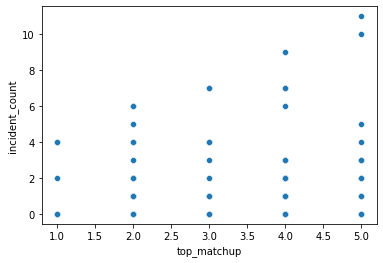

In [60]:
# scatterplot of high-incident games vs. hour
sns.scatterplot(df_onerow['top_matchup'], df_onerow['incident_count'])

<AxesSubplot:xlabel='incident_hour', ylabel='Count'>

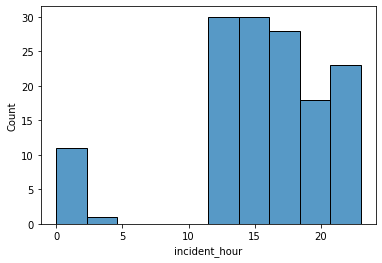

In [61]:
sns.histplot(df[(df['rivalry'] == 1) & (df['sport'] == 'football')]['incident_hour'])

In [62]:
df['offense_name'] = df['offense_name'].replace(np.nan, '99')

In [63]:
# correlation of crime with hour
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(list(df['offense_name']))
df['off_value'] = enc.transform(df['offense_name'])

<AxesSubplot:xlabel='school_points', ylabel='Count'>

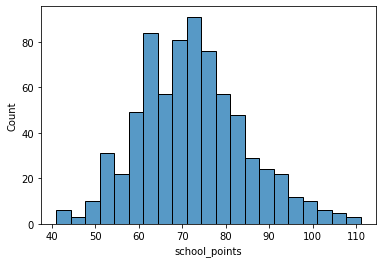

In [64]:
sns.histplot(df_onerow[df_onerow['sport'] == 'basketball']['school_points'])

<AxesSubplot:xlabel='school_points', ylabel='Count'>

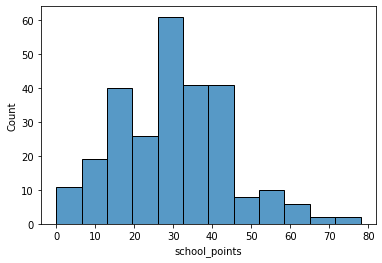

In [65]:
sns.histplot(df_onerow[df_onerow['sport'] == 'football']['school_points'])

In [66]:
print(df_onerow[df_onerow['sport'] == 'football']['school_points'].mean())
print(df_onerow[df_onerow['sport'] == 'football']['school_points'].std())

29.816479400749063
14.491118292364323


<AxesSubplot:xlabel='score_diff', ylabel='Count'>

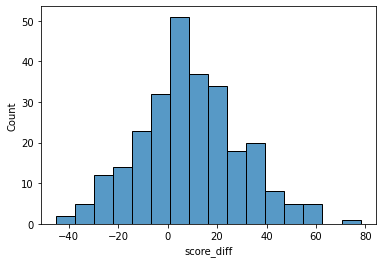

In [67]:
sns.histplot(df_onerow[df_onerow['sport'] == 'football']['score_diff'])

In [68]:
(df_onerow[df_onerow['sport'] == 'football']['score_diff']).describe()

count    267.000000
mean       9.318352
std       20.840059
min      -45.000000
25%       -3.000000
50%        7.000000
75%       23.000000
max       78.000000
Name: score_diff, dtype: float64

In [69]:
df_onerow[df_onerow['sport'] == 'football']['incident_count'].describe()

count    267.000000
mean       2.674157
std        2.362498
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       12.000000
Name: incident_count, dtype: float64

<AxesSubplot:xlabel='incident_count', ylabel='Count'>

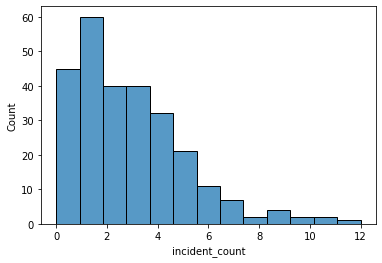

In [70]:
sns.histplot(df_onerow[df_onerow['sport'] == 'football']['incident_count'])